### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Line Detection with Canny Algorithm**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction

The Canny algorithm is a widely used method in computer vision for edge detection. Its goal is to identify significant edges in an image while minimizing noise and maximizing accuracy. It consists of the following steps:

1. **Smoothing with a Gaussian filter:** A Gaussian filter is applied to reduce noise in the image before computing the edges.

2. **Gradient calculation:** Operators such as Sobel are used to detect intensity changes in the image.

3. **Non-Maximum Suppression (NMS):** Weak responses that do not correspond to actual edges are eliminated.

4. **Hysteresis thresholding:** Two thresholds (high and low) are applied to classify edges as strong or weak, ensuring proper edge connectivity.

**Considerations when using this algorithm:**

- **The value of $\sigma$ (sigma):** This refers to the standard deviation of the Gaussian filter and determines the degree of smoothing applied to the image. Larger values result in stronger smoothing, while smaller values preserve more details.

- **Threshold selection:** The quality of edge detection depends on these thresholds. If they are too high, some edges may be lost; if they are too low, false edges may be detected.

- **Noise:** Noise can produce false edges when computing gradients. This is mitigated using the Gaussian filter, Non-Maximum Suppression (NMS), and hysteresis thresholding.

- **Image scale:** High-resolution images may lead to excessive edge detection, whereas low-resolution images may miss important details.

- **Lighting and contrast:** Since the algorithm is based on intensity gradients, uniform lighting and high contrast help detect real edges and avoid false detections.


### Importing libraries

In [1]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter as gauss
from scipy.ndimage.filters import median_filter as med

/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_63854/29601034.py:9: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve
/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_63854/29601034.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gauss
/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_63854/29601034.py:11: DeprecationWarning: Please import `median_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import median_filter as med


### Loading Images

In [2]:
# Loading images
car = cv2.imread("data/cars.jpg")
car_image = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)

In [3]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """

    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if i < len(labels):
                ax.set_title(labels[i])
            # dont show the axis ticks
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots
    plt.tight_layout()
    plt.show()


### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

### 1.1 Sigma Parameter $\sigma$

In [4]:
# Change this parameter
sigma_ = [1, 1.5, 5, 10, 20]

### 1.2 Kernel Size Parameter

In [5]:
kernel_size = (5,5)

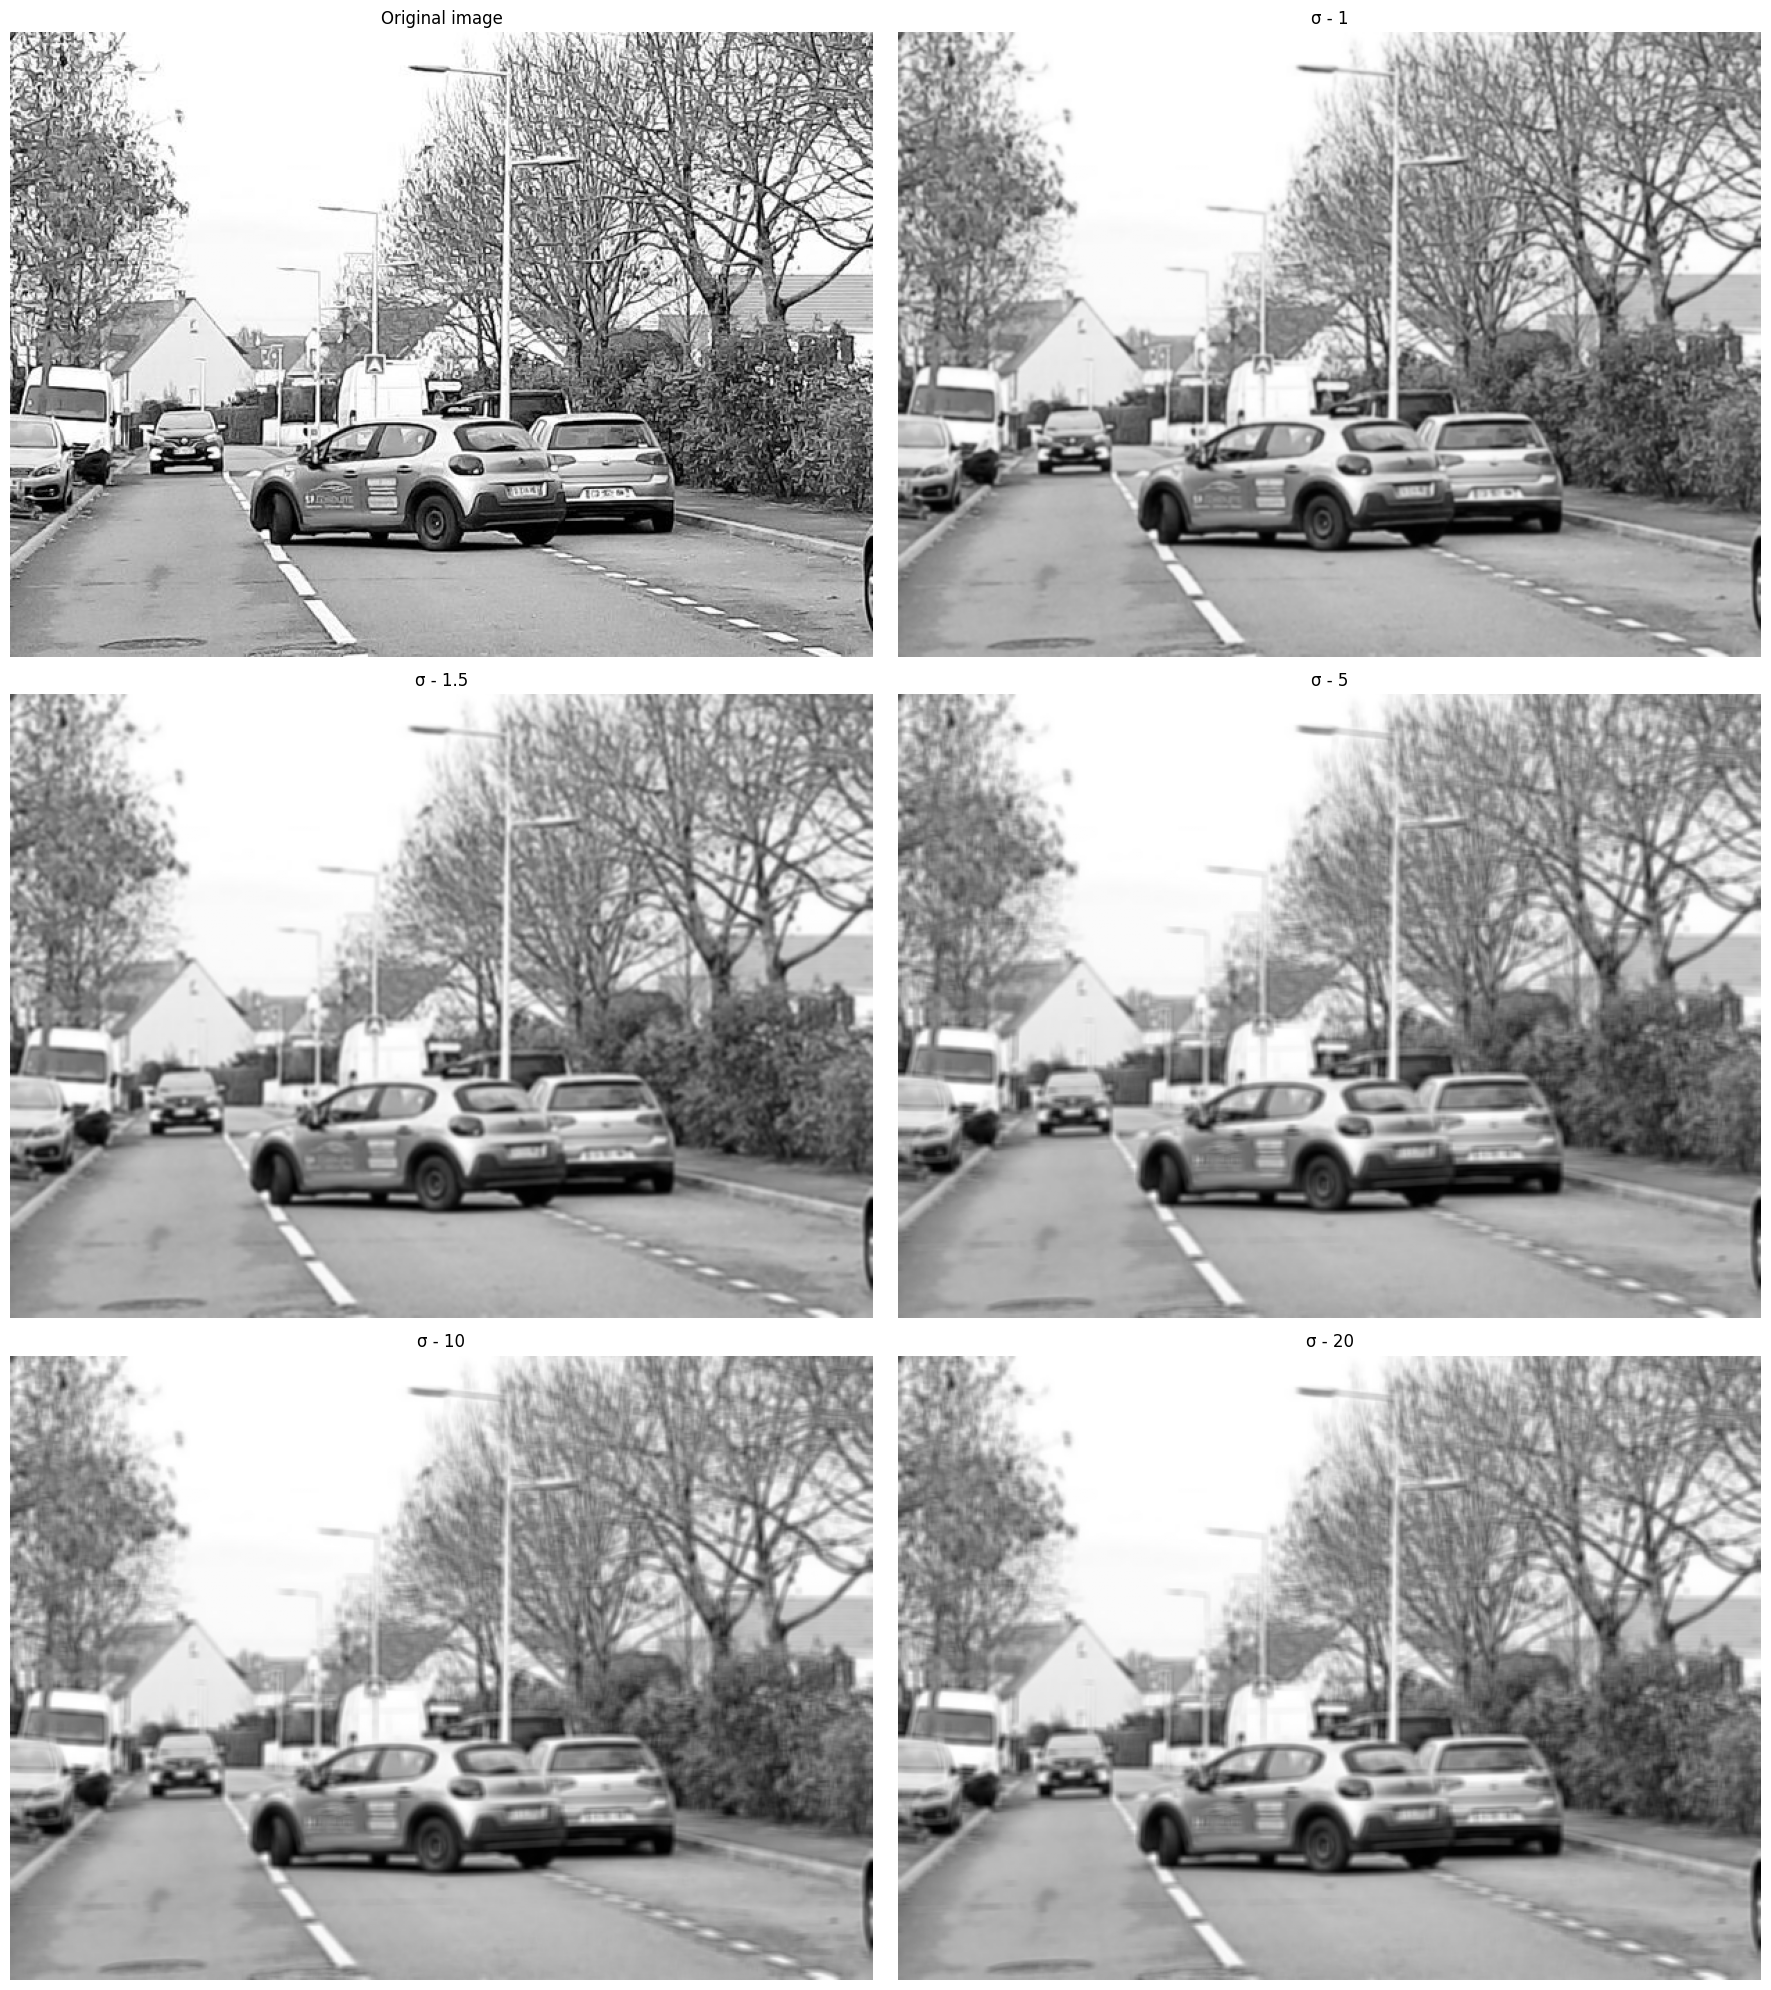

In [6]:
def noise_removal(image, kernel_size, sigma_, labels = []):
    # try different 
    transformed_images = [cv2.GaussianBlur(image, kernel_size, sigma) for sigma in sigma_]
    # set original image
    transformed_images[:0] = [image]
    
    if len(labels) < 1:
        sigma_symbol = "\u03C3"
        labels = [f"{sigma_symbol} - {str(sigma)}" for sigma in sigma_]
        labels[:0] =[ "Original image"]
    
    return transformed_images, labels

blured_images, labels = noise_removal(car_image.copy(), kernel_size, sigma_)

plot_images(blured_images, labels, nrows=3, ncols=2, figsize=(18,20))

Changing the sigma parameter in a Gaussian filter allows us to observe how the image is affected by the smoothing process. The higher the sigma value, the more blurred the image becomes. This is because the Gaussian kernel becomes larger, and the values of the kernel are more spread out, resulting in a wider area of influence for each pixel.

When sigma is small, the Gaussian kernel is more concentrated, preserving finer details and edges in the image. However, as sigma increases, the kernel encompasses a broader range of neighboring pixels, leading to a stronger averaging effect. This averaging reduces high-frequency noise and sharp edges, resulting in a smoother, more blurred appearance.

### 2. Canny with and without Noise Reduction


In [7]:
labels.insert(1,"Canny Detector without noise removal")

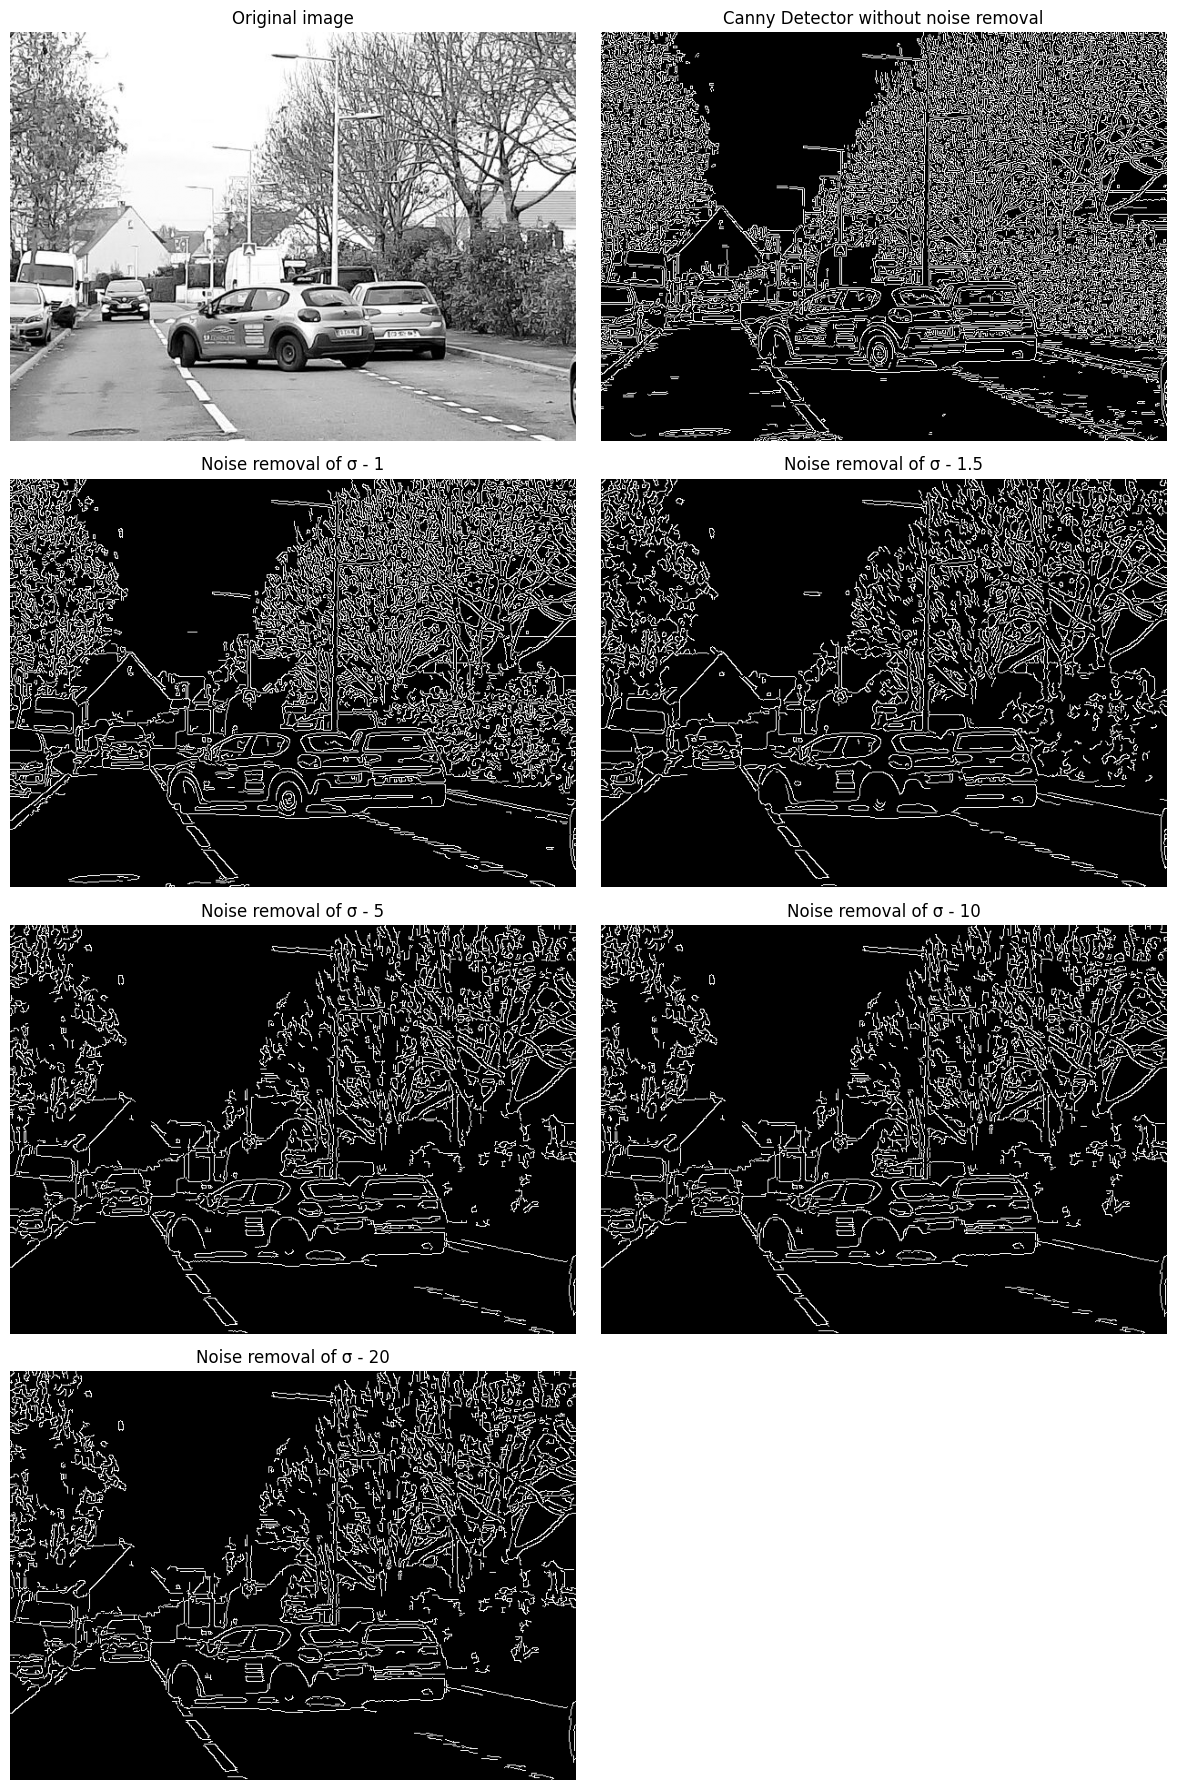

In [8]:
def canny(images, low_umbral=100, high_umbral=200):
    # applying image detection
    transformed_images = [cv2.Canny(image, low_umbral, high_umbral) for image in images]
    transformed_images[:0] = [car_image]
    return transformed_images


labels[2:] = [f"Noise removal of {label}" for label in labels[2:] ]
plot_images(canny(blured_images), labels, ncols=2, nrows=4, figsize=(12,18))

In [9]:
def callback(input):
    pass

def canny2(image, sigma=1, kernel_size=(3,3)):
    withname = "canny"
    cv2.namedWindow(withname)
    cv2.createTrackbar("min_threshold", withname, 0, 255, callback)
    cv2.createTrackbar("max_threshold", withname, 0, 255, callback)
    cv2.createTrackbar("sigma", withname, 0, 50, callback)
    # image = 
    
    while True:
        if cv2.waitKey(1) == ord("q"):
            break
        min_threshold = cv2.getTrackbarPos("min_threshold", withname)
        max_threshold = cv2.getTrackbarPos("max_threshold", withname)
        sigma = cv2.getTrackbarPos("sigma", withname)
        
        
        cannyEdge = cv2.Canny(cv2.GaussianBlur(image, kernel_size, sigma), min_threshold, max_threshold)
        cv2.imshow(withname, cannyEdge)
        
    cv2.destroyAllWindows()

# testing with image 1
canny2(car_image, 1.5)

2025-02-16 18:17:05.635 python[63854:2993413] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-16 18:17:05.636 python[63854:2993413] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

### Conclusion

In this notebook, we explored the effects of various parameters on edge detection using the Canny algorithm. Our key observations include:

a) **Modifying the Sigma Value**: By adjusting the sigma value in the Gaussian filter, we observed significant changes in the detected lines. Higher sigma values resulted in more blurred images, which in turn affected the sharpness and clarity of the detected edges. Lower sigma values preserved finer details and edges, while higher values smoothed out noise and reduced the number of detected edges.

b) **Analyzing the Behavior of the Canny Detector**: We compared the performance of the Canny edge detector with and without noise removal. Without noise removal, the detector was highly sensitive to noise, resulting in a large number of false edges. After applying Gaussian blur for noise removal, the detector produced cleaner and more accurate edge maps, demonstrating the importance of pre-processing steps in edge detection.

c) **Experimenting with Different Images**: We experimented with images containing varying amounts of lines and textures. The Canny algorithm's performance varied depending on the complexity of the image. Images with more lines and textures required careful tuning of the sigma and threshold parameters to achieve optimal edge detection results.

Overall, this notebook provided valuable insights into the impact of different parameters on the Canny edge detection algorithm and highlighted the importance of noise reduction in achieving accurate edge detection.

### References


- OpenCV. (n.d.). Canny edge detection. OpenCV Documentation. Retrieved February 16, 2025, from https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

- OpenCV. (n.d.). Canny edge detector. OpenCV Documentation. Retrieved February 16, 2025, from https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html

- Rosebrock, A. (2021, May 12). OpenCV edge detection (cv2.Canny). PyImageSearch. Retrieved February 16, 2025, from https://pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/